In [7]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx
import matplotlib as mpl

from scaling.constants import *
from scaling.laws import *
from scaling.shared import *

'''load all the data'''

model_dir = "exp_data/models" # has all the loss evaluations
cc_mults = [0.25, 0.5, 1.0, 2.0, 4.0, 8.0, 16.0, 32.0] # multiply each by 20 to get the token multiplier
datasets = ["c4_original", "rpj", "rw_original"]
downstreams = ["avg", "avg_subset"] # the 46-task and 17-task splits
eval_dir = "exp_data/evals" # has all the downstream evaluations
val_dataset = "c4_val" # dataset for loss computation
df = parse_model_jsons(model_dir, cc_mults=cc_mults, datasets=datasets, eval_dir=eval_dir)
print(f"num models: {len(df.index)}")
print(f"fields: {df.columns.tolist()}")

num models: 104
fields: ['cc_mult', 'dataset_name', 'name', 'model_name', 'N', 'D', 'flops', 'color', 'shape', 'tok_mult', 'loss_openlm', 'loss_upper_openlm', 'loss_lower_openlm', 'loss_c4_val', 'loss_upper_c4_val', 'loss_lower_c4_val', 'loss_paloma_c4_en', 'loss_upper_paloma_c4_en', 'loss_lower_paloma_c4_en', 'loss_paloma_dolma_100_programing_languages', 'loss_upper_paloma_dolma_100_programing_languages', 'loss_lower_paloma_dolma_100_programing_languages', 'loss_paloma_falcon-refinedweb', 'loss_upper_paloma_falcon-refinedweb', 'loss_lower_paloma_falcon-refinedweb', 'loss_paloma_ptb', 'loss_upper_paloma_ptb', 'loss_lower_paloma_ptb', 'loss_paloma_redpajama', 'loss_upper_paloma_redpajama', 'loss_lower_paloma_redpajama', 'loss_val_de-en_100', 'loss_upper_val_de-en_100', 'loss_lower_val_de-en_100', 'err_agi_eval_lsat_ar', 'err_agi_eval_lsat_rc', 'err_agi_eval_lsat_lr', 'err_agi_eval_sat_en', 'err_arc_easy', 'err_arc_challenge', 'err_bbq', 'err_bigbench_conceptual_combinations', 'err_bigbe

In [8]:
'''fit scaling laws with all the defaults in Table 2 for our paper'''
scaling_law_dict = {}

# NOTE: C4 eval used to as the loss evaluation here
for dataset in datasets:
    for downstream in ["avg", "avg_subset"]:
        # Use 1.4B, M=20 run for fitting the top-1 error scaling laws
        ((a, b, alpha_c, E), (k, gamma, epsilon)), (loss_points, error_points) = fit_ds(
            dataset,
            val_dataset,
            downstream,
            model_dir,
            eval_dir,
            cc_mults,
            True,
            True,
        )
        scaling_law_dict[f"train={dataset}-loss={val_dataset}-downstream={downstream}"] = {
            "loss_scaling": (a, b, alpha_c, E),
            "error_scaling": (k, gamma, epsilon),
            "loss_points": loss_points,
            "error_points": error_points,
        }

In [15]:
scaling_law_dict.keys()

dict_keys(['train=c4_original-loss=c4_val-downstream=avg', 'train=c4_original-loss=c4_val-downstream=avg_subset', 'train=rpj-loss=c4_val-downstream=avg', 'train=rpj-loss=c4_val-downstream=avg_subset', 'train=rw_original-loss=c4_val-downstream=avg', 'train=rw_original-loss=c4_val-downstream=avg_subset'])

In [16]:
scaling_law_dict['train=c4_original-loss=c4_val-downstream=avg']['error_scaling']

(np.float64(1.2885164150631179),
 np.float64(0.9721644120319103),
 np.float64(0.75894944023892))

/var/folders/9n/v9z4_18x30v6p5scg9lfyb4h0000gn/T/ipykernel_3547/2199513037.py:41: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.scatter(
/var/folders/9n/v9z4_18x30v6p5scg9lfyb4h0000gn/T/ipykernel_3547/2199513037.py:63: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.scatter(
/var/folders/9n/v9z4_18x30v6p5scg9lfyb4h0000gn/T/ipykernel_3547/2199513037.py:134: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.scatter(


relative error predicting (open_lm_1b, M=640.0) C4 eval loss: 64.1865%
relative error predicting (open_lm_7b, M=20.0) C4 eval loss: 69.4040%
relative error predicting (open_lm_1b, M=640.0) 17-task split top-1 error: 55.6822%
relative error predicting (open_lm_7b, M=20.0) 17-task split top-1 error: 56.8633%


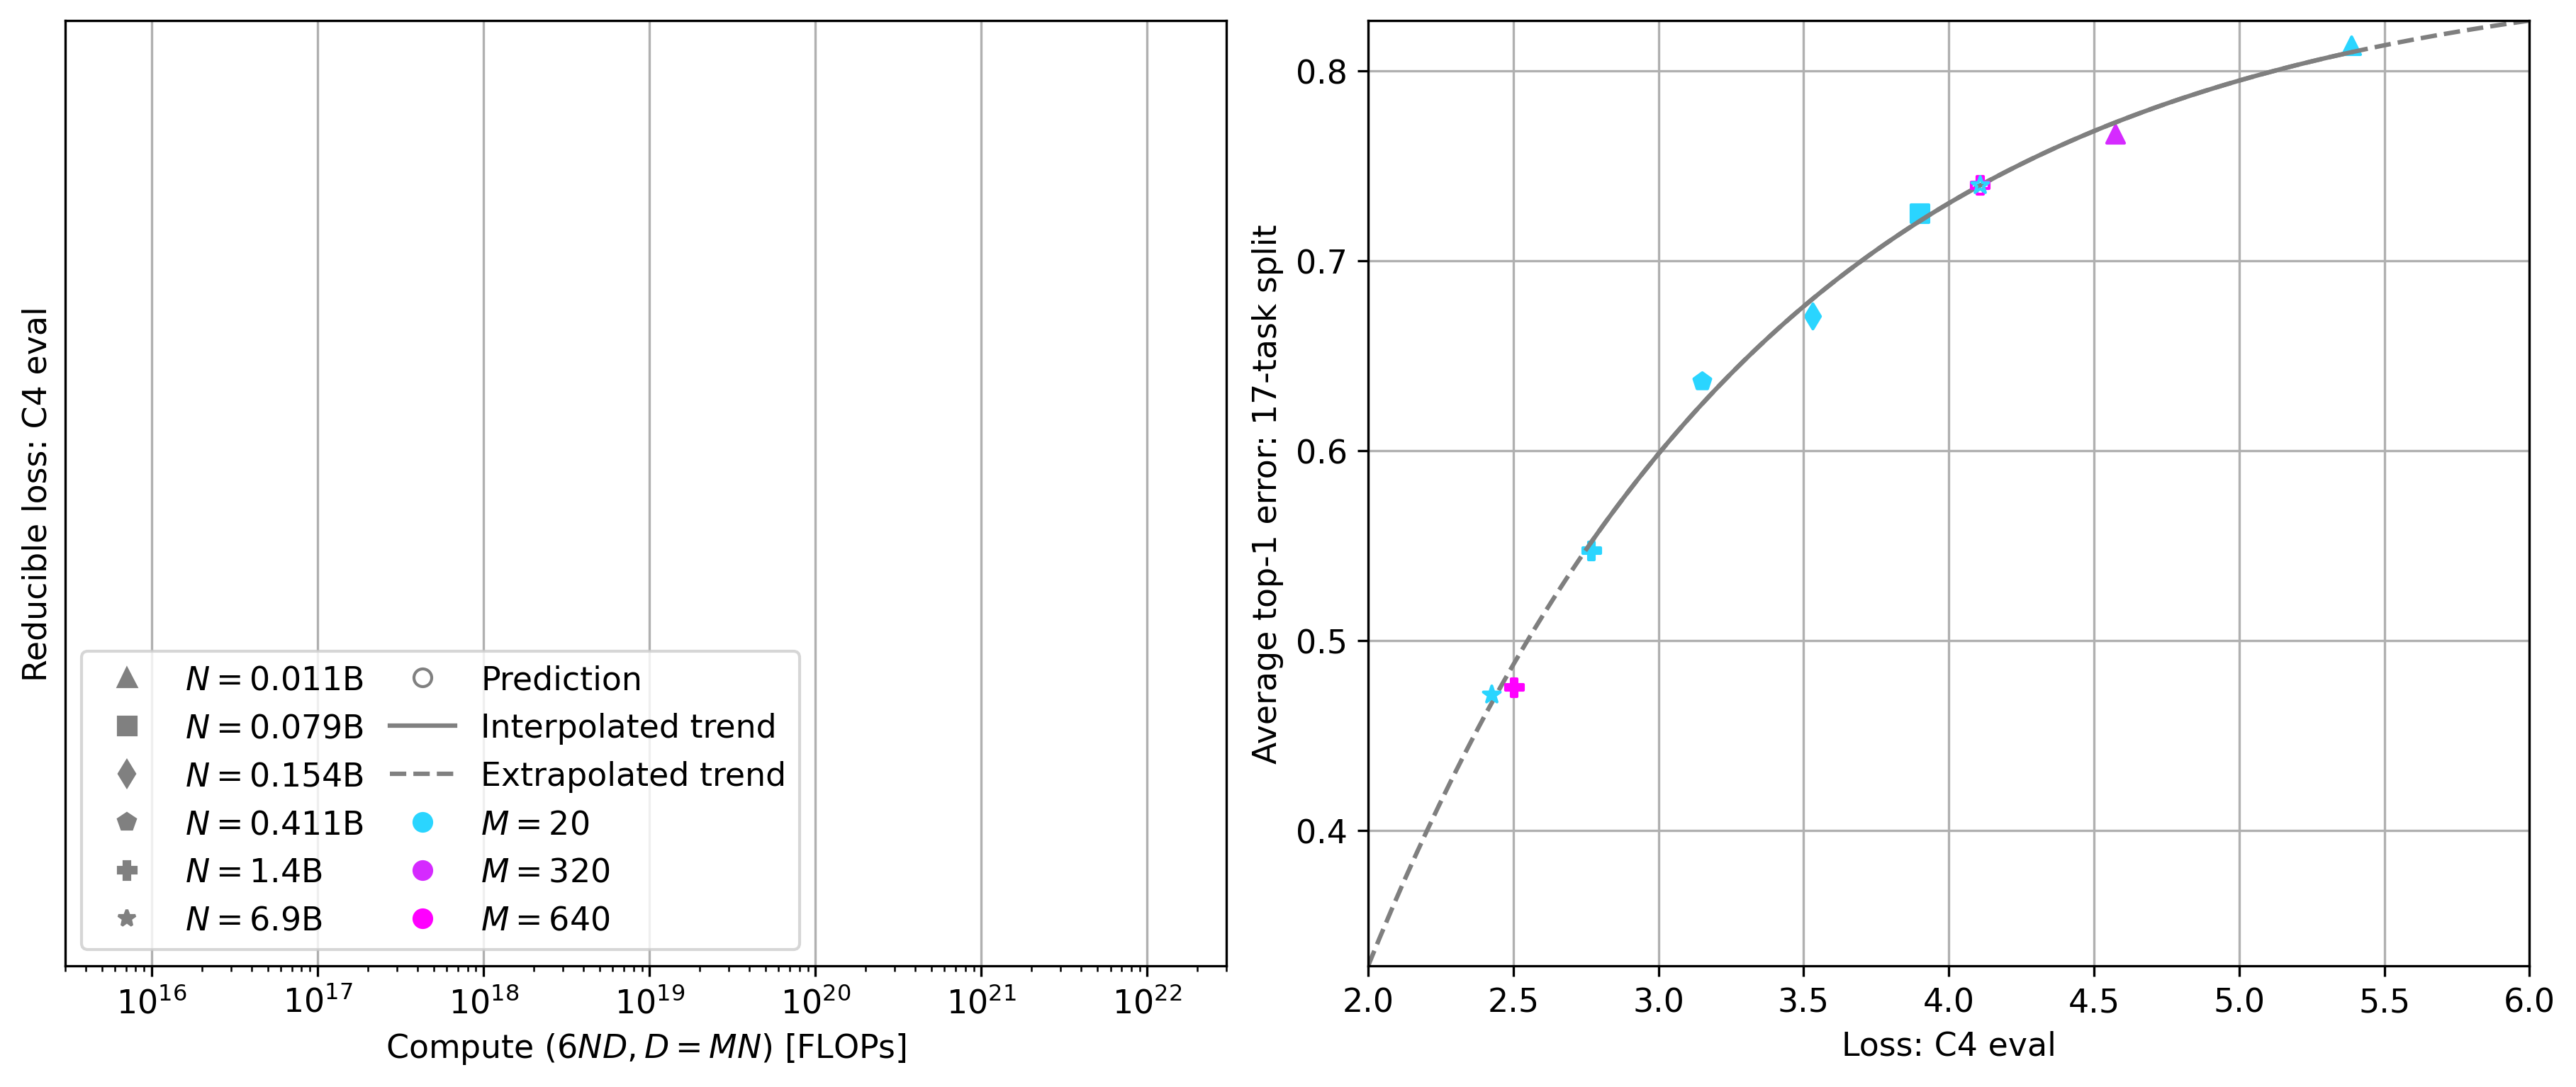

In [9]:
'''reproduce figure 1'''

mpl.rcParams["figure.dpi"] = 300
font = {
    "size": 11,
}
mpl.rc("font", **font)

# setup axes
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5), constrained_layout=True)

# axis setup
ax = axes[0]
ax_down = axes[1]
ax.set_ylabel(f"Reducible loss: {VAL_FRIENDLIES[val_dataset]}")
ax.set_xlabel("Compute ($6ND, D=MN$) [FLOPs]")
ax.set_yscale("log")
ax.set_yticks([1.0, 2.0, 3.0])
ax.get_yaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
ax.set_xscale("log")
ax.grid(which="major", ls="-")
ax.margins(y=0.0, x=0.0)

ax_down.set_ylabel(f"Average top-1 error: {VAL_FRIENDLIES[downstream]}")
ax_down.set_xlabel(f"Loss: {VAL_FRIENDLIES[val_dataset]}")
ax_down.get_yaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
ax_down.grid(which="major", ls="-")
ax_down.margins(y=0.0, x=0.0)

# get the redpajama scaling laws for the 17-task split
(a, b, alpha_c, E) = scaling_law_dict["train=rpj-loss=c4_val-downstream=avg_subset"]["loss_scaling"]
(k, gamma, epsilon) = scaling_law_dict["train=rpj-loss=c4_val-downstream=avg_subset"]["error_scaling"]

cmap = plt.get_cmap("cool")
cNorm = colors.LogNorm(vmin=0.5, vmax=32.0)  # values range from M=10 to M=640 token mults
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cmap)

# plot gt points for loss scaling
loss_points = scaling_law_dict["train=rpj-loss=c4_val-downstream=avg_subset"]["loss_points"]
for i in range(len(loss_points["flops"])):
    ax.scatter(
        loss_points["flops"][i],
        loss_points["loss"][i] - E,
        marker=loss_points["shapes"][i],
        color=scalarMap.to_rgba(loss_points["mults"][i]/20.),
        zorder=9,
    )

# plot gt target points
target_df = df[(((df["model_name"] == "open_lm_1b") | (df["model_name"] == "open_lm_7b")) & (df["dataset_name"] == "rpj"))]
target_df = target_df[target_df["flops"] > 248761226153164800000] # dont want the 1.4B, M=20 model
target_flops = target_df["flops"].tolist()
target_loss = target_df[f"loss_{val_dataset}"].tolist()
target_shape = target_df["shape"].tolist()
target_mults = target_df["tok_mult"].tolist()
target_names = target_df["model_name"].tolist()
target_error = target_df[f"err_{downstream}"].tolist()

target_loss_dict = {}

for i in range(len(target_flops)):
    target_loss_dict[(target_names[i], target_mults[i]/20)] = target_loss[i]
    ax.scatter(
        target_flops[i],
        target_loss[i] - E,
        marker=target_shape[i],
        color=scalarMap.to_rgba(target_mults[i]/20.),
        zorder=9,
    )

# plot extrapolation for loss scaling
computes = [3e15, 3e17, 3e18, 3e19, 3e20, 3e22]
n = np.sqrt(np.array(computes).astype(float) / (6 * 32.0 * 20)).tolist()
y = (
    sigmoid_ours(
        np.array([n, [640.0] * len(computes)]).astype(float),
        *(a, b, alpha_c, E),
    )
    - E
)
ax.plot(computes, y, linestyle="dashed", color="tab:grey")

n = np.sqrt(np.array(computes).astype(float) / (6 * 1.0 * 20)).tolist()
y = (
    sigmoid_ours(
        np.array([n, [20.0] * len(computes)]).astype(float),
        *(a, b, alpha_c, E),
    )
    - E
)
ax.plot(computes, y, linestyle="dashed", color="tab:grey")

for N in sorted(PARAM_SHAPES.keys()):
    start_compute = (N**2) * 20. * 6
    end_compute = 3e22

    ms = []
    for c in np.linspace(np.log10(start_compute), np.log10(end_compute), 10):
        m = np.power(10, c) / ((N**2) * 6)
        ms.append(m)

    xs = ((N**2) * np.array(ms) * 6).tolist()
    ys = (
        sigmoid_ours(np.array([[N for _ in range(len(xs))], ms]).astype(float), *(a, b, alpha_c, E))
        - E
    )

    ax.plot(
        xs, ys, color="tab:grey", linestyle="dashed"
    )  
    

# plot interpolation for loss scaling
y = (
    sigmoid_ours(
        np.array([[min(loss_points["params"]), max(loss_points["params"])], [20.0, 20.0]]).astype(float),
        *(a, b, alpha_c, E),
    )
    - E
)
ax.plot([min(loss_points["flops"]), max(loss_points["flops"])], y, color="tab:grey")

ms_11m = np.linspace(1.0, 16.0, 100) * 20
ns_11m = [NAME_PARAMS["d=96_l=8_h=4"] for _ in range(len(ms_11m))]
ys_11m = sigmoid_ours(np.array([ns_11m, ms_11m.tolist()]), *(a, b, alpha_c, E)).astype(float) - E
xs_11m = [6 * m * 10569312**2 for m in ms_11m]
ax.plot(xs_11m, ys_11m, color="tab:grey")

# plot predictions at 6.9B, 138B tokens and 1.4B, 900B tokens
for name, m in [("open_lm_1b", 32.), ("open_lm_7b", 1.)]:
    N = NAME_PARAMS[name]
    compute = (N**2) * 20 * m * 6
    loss_pred = sigmoid_ours(np.array([[N], [20 * m]]), *(a, b, alpha_c, E))
    ax.scatter(
        [compute],
        [loss_pred - E],
        zorder=9,
        marker=PARAM_SHAPES[N],
        facecolors='none',
        edgecolors=scalarMap.to_rgba(m),
    )
    
    gt_loss = target_loss_dict[(name, m)]
    print(f"relative error predicting ({name}, M={m*20}) {VAL_FRIENDLIES[val_dataset]} loss: {abs(loss_pred - gt_loss).item() / gt_loss:.4%}")

# plot gt points for error scaling
error_points = scaling_law_dict["train=rpj-loss=c4_val-downstream=avg_subset"]["error_points"]
for i in range(len(error_points["flops"])):
    ax_down.scatter(
        error_points["loss"][i],
        error_points["error"][i],
        marker=error_points["shapes"][i],
        color=scalarMap.to_rgba(error_points["mults"][i]/20.)
    )


# target error plotting
target_error_dict = {}

for i in range(len(target_flops)):
    target_error_dict[(target_names[i], target_mults[i]/20)] = target_error[i]
    ax_down.scatter(
        target_loss[i],
        target_error[i],
        marker=target_shape[i],
        color=scalarMap.to_rgba(target_mults[i]/20.),
        zorder=9,
    )

x_range = np.linspace(2.0, 6.0, 100)
ax_down.plot(x_range, decay_ours(x_range, *(k, gamma, epsilon)) , linestyle="dashed", color="tab:grey")

x_range = np.linspace(min(error_points["loss"]), max(error_points["loss"]), 100)
ax_down.plot(x_range, decay_ours(x_range, *(k, gamma, epsilon)), color="tab:grey")

# plot predictions at 6.9B, 138B tokens and 1.4B, 900B tokens
for name, m in [("open_lm_1b", 32.), ("open_lm_7b", 1.)]:
    N = NAME_PARAMS[name]
    compute = (N**2) * 20 * m * 6
    loss_pred = sigmoid_ours(np.array([[N], [20 * m]]), *(a, b, alpha_c, E))
    error_pred = decay_ours(loss_pred, *(k, gamma, epsilon))
    
    ax_down.scatter(
        [loss_pred],
        [error_pred],
        zorder=9,
        marker=PARAM_SHAPES[N],
        facecolors='none',
        edgecolors=scalarMap.to_rgba(m),
    )
    
    gt_error = target_error_dict[(name, m)]
    print(f"relative error predicting ({name}, M={m*20}) {VAL_FRIENDLIES[downstream]} top-1 error: {abs(error_pred - gt_error).item() / gt_error:.4%}")

# label=label,
# color=color,
# marker=marker,
# linestyle=linestyle,
labels = []
for name in MODEL_FRINDLIES:
    labels.append(
        ("$N = $" + MODEL_FRINDLIES[name], "grey", MODEL_SHAPES[name], "", "full")
    )

labels.extend(
    [
        ("Prediction", "grey", "o", "", "none"),
        ("Interpolated trend", "grey", "", "-", "full"),
        ("Extrapolated trend", "grey", "", "--", "full"),
        ("$M = 20$", scalarMap.to_rgba(1.0), "o", "", "full"),
        ("$M = 320$", scalarMap.to_rgba(16.0), "o", "", "full"),
        ("$M = 640$", scalarMap.to_rgba(32.0), "o", "", "full"),
    ]
)

legend_helper(ax, labels)

In [ ]:
'''your fun scaling law exploration here!'''
pass